# Эксперименты с апроксимацией математической функции

[Открыть в Colab](https://colab.research.google.com/github/tiendil/public-jupyter-notebooks/blob/first-notebook/simplest-dl-workflow/notebook.ipynb)

[Мой блог](https://tiendil.org)


Этот notebook — результат моих первых экспериментов при изучении Deep Learning. 

Он точно не является образцом правильной работы с DL, так как на текущий момент в DL я полный ноль.

В то же время, тут можно найти работающий (надеюсь) пример с примечаниями от новичка новичкам.

## Цель

Пощупать DL собственными руками «от начала до конца».

## Задачи

1. [x] Пройти весь поток решения задачи машинного обучения с Keras.
1. [x] Разобраться с выбором устройства для обучения сети: GPU, CPU.
1. [x] Разобраться с визуализацией прогресса.

## Материалы

1. [Training & evaluation with the built-in methods](https://keras.io/guides/training_with_built_in_methods/)

## План

1. [x] Выбрать функцию для оптимизации.
1. [x] Сгенерировать данные для неё с помощью numpy.
1. [x] Преобразовать в Dataset.
1. [x] Создать модель.
1. [x] Визуализировать модель.
1. [x] Обучить модель с отображением прогресса.
1. [x] Проверить модель вручную.
1. [x] Визуализировать данные с помощью TensorBoard.

## Подготовка

Notebook запускался в кастомизированном docker контейнере.

Подробнее про мои злоключения с настройкой tensorflow + CUDA можно почитать в блоге: [нельзя просто так взять и запустить DL](https://tiendil.org/you-cant-just-take-and-run-dl).

Официальная документация о [запуске tensorflow через docker](https://www.tensorflow.org/install/docker).

Dockerfile: 

```
FROM tensorflow/tensorflow:2.5.0-gpu-jupyter

RUN apt-get update && apt-get install -y graphviz

RUN pip install --upgrade pip

COPY requirements.txt ./

RUN pip install -r ./requirements.txt
```

requirements.txt:
```
pydot==1.4.2
livelossplot==0.5.4
```

Если вы запускаете notebook в Google Colab, pydot и livelossplot должны доставиться следующим кодом.

Если вы запускаете notebook в Google Colab, **не забудьте указать runtime type — GPU**.

In [43]:
if 'google.colab' in get_ipython().extension_manager.loaded:
    !apt-get -qq install -y graphviz && pip install pydot==1.4.2 livelossplot==0.5.4

## Инициализация

In [44]:
# Импортируем нужные пакеты.
# Настраиваем самые важные параметры.

import os
import random
import logging
import datetime

# Это нужно для более правильного и красивого вывода.
# На сколько я понимаю, использовать print — моветон.
from IPython.display import display, Markdown, Image

# Меняем уровень логирования tensorflow ПЕРЕД его импортом.
# Если это не сделать, библиотека будет выводить кучу сообщений информационного характера. 
# Ради интереса можете закомментировать следующую строчку и почитать их — познавательно.
# Подробнее смотрите тут: https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Раскомментировать, если нунжно расширение TensorBoard для Jupyter.
# Я решил запускать TensorBoard отдельно, поэтому мне оно не нужно.
# Перед подключением проверяем, не подключено ли оно уже, иначе при повторном запуске кода Jupyter будет ругаться.
#if 'tensorboard' not in get_ipython().extension_manager.loaded:
#    display(Markdown('Load TensorBoard extension'))
#    %load_ext tensorboard

import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

from livelossplot import PlotLossesKerasTF

# Настраиваем оставшиеся логеры
logging.getLogger().setLevel(logging.WARNING)

tf.get_logger().setLevel(logging.WARNING)
tf.autograph.set_verbosity(1)

# Включаем строгий режим операций для numpy — при любом warning будет кидаться ошибка
# Полезно, чтобы не напутать с типами данных. Особенно, если логирование отключено/уменьшено.
old_settings = np.seterr('raise')

# Проверяем есть ли доступные GPI
gpus_number = len(tf.config.list_physical_devices("GPU"))
display(Markdown(f'Num GPUs Available: {gpus_number}'))

if gpus_number == 0:
    raise RuntimeError('No GPUs found, learning process will be too slow. In Google Colab set runtime type — GPU.')

Num GPUs Available: 1

In [45]:
# Фиксируем генераторы случайных чисел для воспроизводимости.
# Я не уверен, что это правильный способ фиксации или что он полный.
# Помещено тут, чтобы не забыть в будущем какие нюансы могут быть с обучением.
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Очищаем данные Keras. 
# Добавлено, чтобы освобождать память видеокарты. 
# Это важно, если, например, вы поочерёдно запускаете несколько notebook. 
tf.keras.backend.clear_session()

## Вспомогательные функции

In [46]:
# Некоторые вспомогательные функции, может пригодятся в будущем.

# Если в input находятся значения из интервала [0, 1], то на выходе будут значения из [left, right].
def normalized_to_interval(input, left, right):
    return (right - left) * input + left


# Разделяет данные в dataset на несколько частей заданного размера.
def split_dataset(data, *parts):
    assert len(data) == sum(parts), "dataset size must be equal to sum of parts"
    
    result = []
    
    for part in parts:
        data_part = data.take(part)
        
        result.append(data_part)
        data = data.skip(part)
        
    return result


# Рисует структуру модели средствами Keras. Простой способ визуализировать модель. Но не очень информативный.
# Чтобы эта функция работала, необходимо поставить:
# - graphviz: apt-get install graphviz
# - pydot: pip install pydot
# Если не поставить, tensorflow об этом сообщит.
def display_model(model, name):
    filename = f'/tmp/tmp_model_schema_{name}.png'
    
    keras.utils.plot_model(model, 
                           show_shapes=True, 
                           show_layer_names=True, 
                           show_dtype=True,
                           expand_nested=True,
                           to_file=filename)
    display(Image(filename))

## Определение функции

In [47]:
# Изначально я экспериментировал с функцией от трёх аргументов, но потом понял, что её сложно визуализировать.
# поэтому остановился на функции одного аргумента.

# количество аргументов функции
ARGS = 1 

# f(y) = x + x^2 + e^(sign(x) * min(abs(x), 10))
# выражение sign(x) * min(abs(x), 10) нужно, чтобы ограничить рост функции и избежать переполнения при операциях
def target_function(a):
    return a[0] + a[0]**2.0 + np.exp(np.sign(a[0]) * np.minimum(np.absolute(a[0]), 10.0))

# Мера для расчёта размера выборок
BASE = 1000

TRAIN_EXAMPLES = BASE * 10  # обучающая выборка
VALIDATION_EXAMPLES = BASE  # валидационная выборка
TEST_EXAMPLES = TRAIN_EXAMPLES  # тестовая выборка, использоваться не будет, сугубо для примера

# общее количество точек функции
TOTAL_EXAMPLES = TRAIN_EXAMPLES + VALIDATION_EXAMPLES + TEST_EXAMPLES

# границы интервала, для которого апроксимируем функцию
LEFT = -100
RIGHT = 100

# генерируем случайный набор входных данных и для них считаем значения функции.
rng = np.random.default_rng()

x = normalized_to_interval(rng.random((TOTAL_EXAMPLES, ARGS)), LEFT, RIGHT)
y = np.apply_along_axis(target_function, 1, x)

# формируем dataset и разделяем его на необходимые части
data = tf.data.Dataset.from_tensor_slices((x, y))

data_train, data_validation, datas_test = split_dataset(data, 
                                                        TRAIN_EXAMPLES, 
                                                        VALIDATION_EXAMPLES, 
                                                        TEST_EXAMPLES)

## Конструируем модель

In [48]:
# Собственно модель, к которой я пришёл после череды тыканий пальцем.
# Гарантированно не самая правильная и не самая оптимальная, но для первого блина сойдёт, как мне кажется.

# Для конструирования модели использую функциональное api tensorflow, 
# так мне более интересны нелинейные модели.
# Решил сразу привыкать к их описанию.
def construct_model():
    inputs = keras.Input(shape=(ARGS,))
      
    # Количество нейронов в слое.
    n = 2**10

    # В качестве альтернативы зоопарку функций активации 
    # можно во всех слоях использовать relu и посмотреть как сеть будет сходиться к фукнции в этом случае
    l1 = layers.Dense(n, activation="exponential", use_bias=True)(inputs)
    l2 = layers.Dense(n, activation="linear", use_bias=True)(l1)
    l3 = layers.Dense(n, activation="sigmoid", use_bias=True)(l2)
    l4 = layers.Dense(n, activation="linear", use_bias=True)(l3)
    
    outputs = layers.Dense(1, activation="linear")(l4)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model


model = construct_model()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

## Базовые проверки

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.53754514]], dtype=float32)>

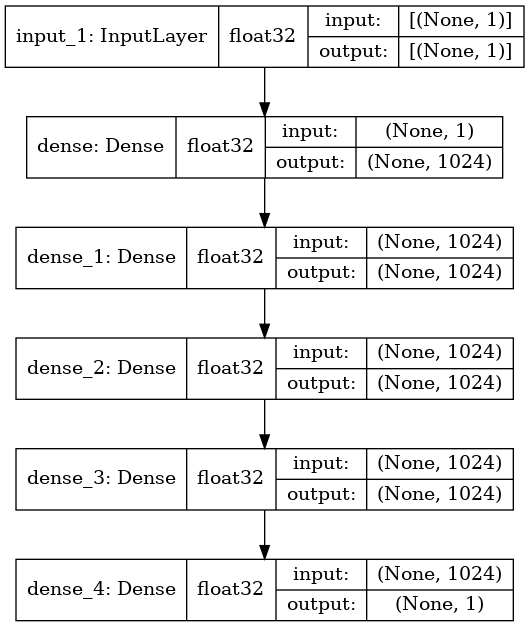

In [49]:
# Проверяем, что модель в принципе что-то считает
display(model(tf.constant(rng.random((1, ARGS)), shape=(1, ARGS))))

# Визуализируем граф модели.
display_model(model, 'model')

## Обучаем модель

In [50]:
# Задаём параметры обучения

# Сколько раз цикл обучения пройдёт по всем обучающим данным
EPOCHS = 100 

# За один шаг будем обучать сеть на таком количестве данных
BATCH_SIZE = int(TOTAL_EXAMPLES * 0.1)


display(Markdown(f'batch size: {BATCH_SIZE}'))
display(Markdown(f'epochs: {EPOCHS}'))

batch size: 2100

epochs: 100

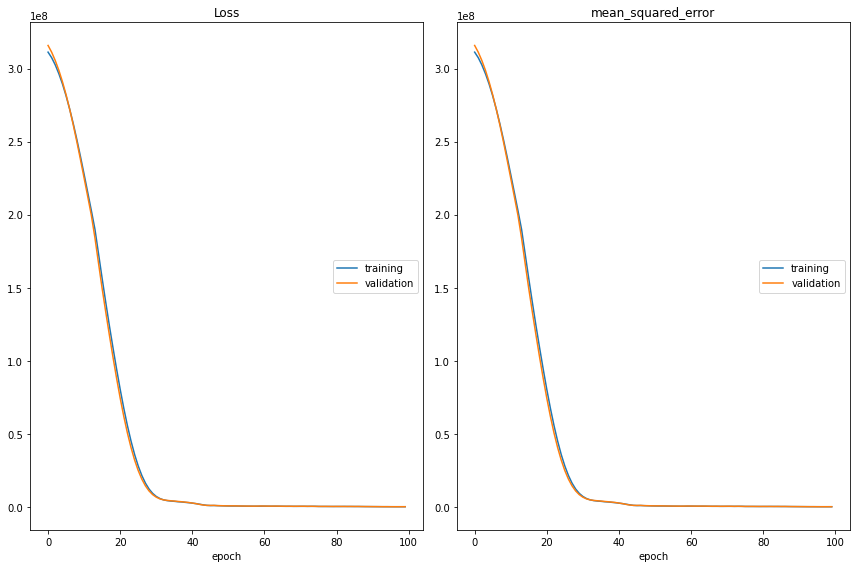

In [51]:
# При обучении сети можно использовать callbacks.
# Они, в том числе, позволяют делать некоторую интерактивную визуализацию.
# Я остановился на двух визуализаторах.

# livelossplot — рисует графики функции потерь и метрик в реальном времени внутри notebook.
# Сделан слегка топорно, поэтому в model.fit приходится выключать режим verbose, чтобы вывод не мигал.

# TensorBoard — идеалогически верный гуи для анализа моделей. Callback пишет логи, которые читает TensorBoard.

# Настраиваем логи для TensorBoard, включено всё, поэтому обучение будет заметно замедлено. 
# Если нужна скорость, отключите лишние фичи или совсем не пишите эти логи.
#tensorboard_logs = os.path.join("logs", datetime.datetime.now().isoformat())
#tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorboard_logs, 
#                                                      histogram_freq=1,
#                                                      write_graph=True,
#                                                      write_images=True,
#                                                      write_steps_per_second=True,
#                                                      update_freq='batch',
#                                                      embeddings_freq=1)


# Запускаем обучение.
# Обратите внимание, с параметром batch_size вышла засада.
# Изначально я работал с родными массивами numpy и включал этот параметр, чтобы делать обучение «по корзинкам».
# После переключения на datasets, обучение сильно замедлилось, — datasets сами умеют разбивать данные на части.
# В документации про batch_size сказано, что его нельзя использовать с datasets, но кто ж её читает :-)
# Поэтому вместо использования batch_size, я явно задают его в самих datasets
history = model.fit(data_train.batch(BATCH_SIZE, drop_remainder=True),
                    #batch_size=BATCH_SIZE, не использовать с datasets
                    epochs=EPOCHS,
                    validation_data=data_validation.batch(len(data_validation)),
                    callbacks=[PlotLossesKerasTF(outputs=['MatplotlibPlot'])],#, tensorboard_callback],
                    verbose=0)

## Сравниваем

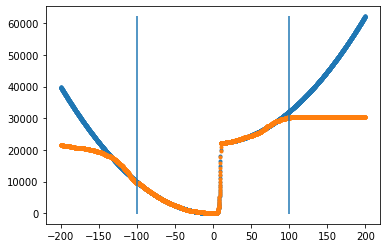

In [52]:
# Визуально проверяем как наша сеть предсказывает функцию

# берём больший интервал, чтобы посмотреть поведение сети за границами (отмечены вертикальными линиями)
check_x = np.expand_dims(np.arange(-200, 200, 0.1), axis=1)
check_y = np.apply_along_axis(target_function, 1, check_x)

plt.scatter(check_x, check_y, marker='.')
plt.scatter(check_x, model(check_x), marker='.')
plt.vlines([LEFT, RIGHT], ymin=np.min(check_x), ymax=np.max(check_y))
plt.show()